In [172]:
import os
import numpy as np
import shutil
import glob
import csv
import cv2 as cv
import nibabel as nib
import matplotlib.pyplot as plt
from genericpath import exists
from typing import Sized
from matplotlib.figure import Figure
import json
from PIL import Image
import pandas as pd
from skimage import color
from skimage import io
from scipy.signal import correlate
from scipy.stats import multivariate_normal
import pandas as pd
from scipy.stats import kurtosis, skew, entropy, median_absolute_deviation
import warnings
import scipy.optimize
import seaborn as sns
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

# Data Loading

In [173]:
df = pd.read_csv(r'D:\OneDrive\JOB\NUXTU\Casos_positivos_de_COVID-19_en_Colombia.csv')
df.head()

,fecha reporte web,ID de caso,Fecha de notificación,Código DIVIPOLA departamento,Nombre departamento,Código DIVIPOLA municipio,Nombre municipio,Edad,Unidad de medida de edad,Sexo,...,Código ISO del país,Nombre del país,Recuperado,Fecha de inicio de síntomas,Fecha de muerte,Fecha de diagnóstico,Fecha de recuperación,Tipo de recuperación,Pertenencia étnica,Nombre del grupo étnico
0,2021-03-04 00:00:00,2265685,2021-03-02 00:00:00,11,BOGOTA,11001,BOGOTA,49,1,M,...,NaN,NaN,Recuperado,2021-02-25 00:00:00,NaN,2021-03-03 00:00:00,2021-03-16 00:00:00,Tiempo,6.0,NaN
1,2021-03-04 00:00:00,2265686,2021-03-02 00:00:00,11,BOGOTA,11001,BOGOTA,49,1,M,...,NaN,NaN,Recuperado,2021-02-23 00:00:00,NaN,2021-03-03 00:00:00,2021-03-16 00:00:00,Tiempo,6.0,NaN
2,2021-03-04 00:00:00,2265687,2021-03-02 00:00:00,11,BOGOTA,11001,BOGOTA,51,1,F,...,NaN,NaN,Recuperado,2021-02-24 00:00:00,NaN,2021-03-03 00:00:00,2021-03-16 00:00:00,Tiempo,6.0,NaN
3,2021-03-04 00:00:00,2265688,2021-03-02 00:00:00,11,BOGOTA,11001,BOGOTA,51,1,F,...,NaN,NaN,Recuperado,2021-02-27 00:00:00,NaN,2021-03-03 00:00:00,2021-03-13 00:00:00,Tiempo,6.0,NaN
4,2021-03-04 00:00:00,2265689,2021-03-02 00:00:00,11,BOGOTA,11001,BOGOTA,51,1,F,...,NaN,NaN,Recuperado,2021-03-01 00:00:00,NaN,2021-03-03 00:00:00,2021-03-16 00:00:00,Tiempo,6.0,NaN


In [174]:
print(df.shape)
print(df.columns)

(6247634, 23)
Index(['fecha reporte web', 'ID de caso', 'Fecha de notificación',
       'Código DIVIPOLA departamento', 'Nombre departamento',
       'Código DIVIPOLA municipio', 'Nombre municipio', 'Edad',
       'Unidad de medida de edad', 'Sexo', 'Tipo de contagio',
       'Ubicación del caso', 'Estado', 'Código ISO del país',
       'Nombre del país', 'Recuperado', 'Fecha de inicio de síntomas',
       'Fecha de muerte', 'Fecha de diagnóstico', 'Fecha de recuperación',
       'Tipo de recuperación', 'Pertenencia étnica',
       'Nombre del grupo étnico'],
      dtype='object')


# Exploratory Data Analysis

The following lines allow to explore columns in the dataset, their values, data type, null entries and how unique values are distributed among columns in order to check if any column can be dropped out due to it's entries. First, the label column which is the subject of prediction is explored

In [175]:
print('Null values:', df.Estado.isnull().sum())
df.Estado.value_counts()

Null values: 30484


Leve         6025656
Fallecido     140603
leve           49905
Moderado         908
Grave             76
LEVE               2
Name: Estado, dtype: int64

Unique labels are:
- Leve: 6075563
- Moderado: 908 entries
- Grave: 76 entries
- Fallecido: 140603 entries
With Nan: 30483 entries

Further preprocessing will require joining 'Leve', 'leve' and 'LEVE' as unique values. The above result shows that classess are unbalanced since leve have more than 6 million entries while grave have only 76. This will be an important insight during training. 

In [176]:
df[df['Estado']=='LEVE'] = 'Leve'
df[df['Estado']=='leve'] = 'Leve'
df.Estado.value_counts()

Leve         6075563
Fallecido     140603
Moderado         908
Grave             76
Name: Estado, dtype: int64

According to the INS, empty "Recuperado" entries are "active" entries, therefore:

In [177]:
df.Recuperado = df.Recuperado.fillna('Activo')
df[df['Recuperado']=='fallecido'] = 'Fallecido'
df.Recuperado.value_counts()

Recuperado    6003952
Fallecido      140603
Activo          53172
Leve            49907
Name: Recuperado, dtype: int64

Useful information can be displaied of all columns in order to verify their data type and null entries

In [76]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6247634 entries, 0 to 6247633
Data columns (total 23 columns):
 #   Column                        Non-Null Count    Dtype 
---  ------                        --------------    ----- 
 0   fecha reporte web             6247634 non-null  object
 1   ID de caso                    6247634 non-null  object
 2   Fecha de notificación         6247634 non-null  object
 3   Código DIVIPOLA departamento  6247634 non-null  object
 4   Nombre departamento           6247634 non-null  object
 5   Código DIVIPOLA municipio     6247634 non-null  object
 6   Nombre municipio              6247634 non-null  object
 7   Edad                          6247634 non-null  object
 8   Unidad de medida de edad      6247634 non-null  object
 9   Sexo                          6247634 non-null  object
 10  Tipo de contagio              6247634 non-null  object
 11  Ubicación del caso            6217150 non-null  object
 12  Estado                        6217150 non-

The above results reveal that four columns have null or NaN data for the mayority of their entries. These are:
- Código ISO del país
- Nombre del país
- Fecha de muerte
- Nombre del grupo étinco

In order to assess if deleting those features will negtively impact our model, unique values and their value count for each is useful. To visualize the full output select "in a text editor".

In [77]:
col = 'Código ISO del país'
print(df[col].value_counts().shape)
pd.options.display.max_rows = 6000
df[col].value_counts()


(100,)


Leve         49907
840.0         1415
484.0          383
724.0          365
Fallecido      295
76.0           274
862.0          175
591.0          154
218.0          125
214.0           99
604.0           68
152.0           66
222.0           57
250.0           44
792.0           34
32.0            26
124.0           25
826.0           24
380.0           24
276.0           23
533.0           23
630.0           22
388.0           22
320.0           15
188.0           14
818.0           13
112.0           12
51.0            10
192.0            9
530.0            9
376.0            8
600.0            6
212.0            6
784.0            6
300.0            5
558.0            5
528.0            5
682.0            5
780.0            5
68.0             5
36.0             5
850.0            4
858.0            4
340.0            4
531.0            4
1724.0           4
620.0            3
756.0            3
1249.0           3
643.0            3
4.0              3
56.0             3
8.0         

In [78]:
col = 'Nombre del país'
print(df[col].value_counts().shape)
df[col].value_counts()


(90,)


Leve                                               49907
ESTADOS UNIDOS DE AMÉRICA                           1412
MÉXICO                                               382
ESPAÑA                                               369
Fallecido                                            295
BRASIL                                               283
VENEZUELA                                            174
PANAMÁ                                               126
ECUADOR                                              126
REPÚBLICA DOMINICANA                                  98
CHILE                                                 68
EL SALVADOR                                           57
PERÚ                                                  50
FRANCIA                                               45
TURQUÍA                                               34
PANAMA                                                30
ARGENTINA                                             26
CANADÁ                         

Since "Nombre del país" and "Código ISO del país" provide the same information and the latter have more entries, "Nombre del país" can be deleted as a feature. The same is true for "Código DIVIPOLA..." of municipalities and departments and the columns with their names. Since codes are unique and names in lower and upper caps are detected as different entries, columns with names of municipalities and departments are deleted while DIVIPOLA codes are kept, since they contain the similar information.

In [178]:
df = df.drop('Nombre del país', axis = 1)
df.shape, df.columns

((6247634, 22),
 Index(['fecha reporte web', 'ID de caso', 'Fecha de notificación',
        'Código DIVIPOLA departamento', 'Nombre departamento',
        'Código DIVIPOLA municipio', 'Nombre municipio', 'Edad',
        'Unidad de medida de edad', 'Sexo', 'Tipo de contagio',
        'Ubicación del caso', 'Estado', 'Código ISO del país', 'Recuperado',
        'Fecha de inicio de síntomas', 'Fecha de muerte',
        'Fecha de diagnóstico', 'Fecha de recuperación', 'Tipo de recuperación',
        'Pertenencia étnica', 'Nombre del grupo étnico'],
       dtype='object'))

In [179]:
print(df['Código DIVIPOLA departamento'].value_counts().shape, df['Nombre departamento'].value_counts().shape)
print(df['Código DIVIPOLA departamento'].value_counts().sum(), df['Nombre departamento'].value_counts().sum())

df = df.drop('Nombre departamento', axis = 1)
df.shape, df.columns

(38,) (42,)
6247634 6247634


((6247634, 21),
 Index(['fecha reporte web', 'ID de caso', 'Fecha de notificación',
        'Código DIVIPOLA departamento', 'Código DIVIPOLA municipio',
        'Nombre municipio', 'Edad', 'Unidad de medida de edad', 'Sexo',
        'Tipo de contagio', 'Ubicación del caso', 'Estado',
        'Código ISO del país', 'Recuperado', 'Fecha de inicio de síntomas',
        'Fecha de muerte', 'Fecha de diagnóstico', 'Fecha de recuperación',
        'Tipo de recuperación', 'Pertenencia étnica',
        'Nombre del grupo étnico'],
       dtype='object'))

In [180]:
print(df['Código DIVIPOLA municipio'].value_counts().shape, df['Nombre municipio'].value_counts().shape)
print(df['Código DIVIPOLA municipio'].value_counts().sum(), df['Nombre municipio'].value_counts().sum())

df = df.drop('Nombre municipio', axis = 1)
df.shape, df.columns

(1123,) (1055,)
6247634 6247634


((6247634, 20),
 Index(['fecha reporte web', 'ID de caso', 'Fecha de notificación',
        'Código DIVIPOLA departamento', 'Código DIVIPOLA municipio', 'Edad',
        'Unidad de medida de edad', 'Sexo', 'Tipo de contagio',
        'Ubicación del caso', 'Estado', 'Código ISO del país', 'Recuperado',
        'Fecha de inicio de síntomas', 'Fecha de muerte',
        'Fecha de diagnóstico', 'Fecha de recuperación', 'Tipo de recuperación',
        'Pertenencia étnica', 'Nombre del grupo étnico'],
       dtype='object'))

For 'Fecha de muerte', further feature extraction/selection analysis will provide more insights on how usefull it will be for our model.

An inspection through the unique entries in "Nombre del grupo étnico" revealed that some misleading information was found since some entries are cities, number, dates, neighbours, but not ethnical groups, e.g., entries like "LA PAZ", "13 DE MAYO", etc. Therefore, this columns will be droped as feature for the models.

In [82]:
col = 'Nombre del grupo étnico'
print(df[col].value_counts().size)
df[col].value_counts()

1855


Leve                                                                                   49907
Por definir                                                                            17190
Sin Comunidad                                                                          11259
ZENU                                                                                    9150
PIJAO                                                                                   4056
PASTO                                                                                   2740
WAYUU                                                                                   2704
MOKANA                                                                                  2290
KANKUAMO                                                                                1965
MUISCA                                                                                  1684
NASA_PAÉZ                                                             

In [181]:
df = df.drop('Nombre del grupo étnico', axis = 1)
df.shape, df.columns

((6247634, 19),
 Index(['fecha reporte web', 'ID de caso', 'Fecha de notificación',
        'Código DIVIPOLA departamento', 'Código DIVIPOLA municipio', 'Edad',
        'Unidad de medida de edad', 'Sexo', 'Tipo de contagio',
        'Ubicación del caso', 'Estado', 'Código ISO del país', 'Recuperado',
        'Fecha de inicio de síntomas', 'Fecha de muerte',
        'Fecha de diagnóstico', 'Fecha de recuperación', 'Tipo de recuperación',
        'Pertenencia étnica'],
       dtype='object'))

Checking for useful patterns in all columns, 49907 rows have 'Leve' as entry and 295 have 'Fallecido' as entry in all columns in the dataframe, therefore, these rows will be deleted from the dataset.

In [84]:
col = 'Pertenencia étnica'
print(df[col].value_counts().size)
df[col].value_counts()

7


6.0          5954974
5.0           135952
1.0            81837
Leve           49907
3.0              405
Fallecido        295
2.0              133
Name: Pertenencia étnica, dtype: int64

In [182]:
df = df[df['Pertenencia étnica'] != 'Leve']
df = df[df['Pertenencia étnica'] != 'Fallecido']

col = 'Pertenencia étnica'
print(df[col].value_counts().size)
df[col].value_counts()

5


6.0    5954974
5.0     135952
1.0      81837
3.0        405
2.0        133
Name: Pertenencia étnica, dtype: int64

In [183]:
df.describe()

,fecha reporte web,ID de caso,Fecha de notificación,Código DIVIPOLA departamento,Código DIVIPOLA municipio,Edad,Unidad de medida de edad,Sexo,Tipo de contagio,Ubicación del caso,Estado,Código ISO del país,Recuperado,Fecha de inicio de síntomas,Fecha de muerte,Fecha de diagnóstico,Fecha de recuperación,Tipo de recuperación,Pertenencia étnica
count,6197432,6197432,6197432,6197432,6197432,6197432,6197432,6197432,6197432,6166948,6166948,3689.0,6197432,5699138,170792,6194677,6003952,6003952,6173301.0
unique,795,6197432,868,36,1121,114,3,4,3,6,4,98.0,3,873,855,864,856,2,5.0
top,2022-01-15 00:00:00,1,2022-01-06 00:00:00,11,11001,30,1,F,Comunitaria,Casa,Leve,840.0,Recuperado,2022-01-03 00:00:00,2021-06-21 00:00:00,2022-01-07 00:00:00,2021-06-15 00:00:00,Tiempo,6.0
freq,35558,1,42640,1822915,1822915,149695,6171721,3305836,4287894,6021502,6025656,1415.0,6003952,37300,716,39621,61034,5076095,5954974.0


For Age to be a reliable feature all entries must have the same time unit. Therefore, months and days entries will be converted to years since the mayority of entries have this unit of meassure.

In [184]:
df['Unidad de medida de edad'].value_counts()

1    6171721
2      23498
3       2213
Name: Unidad de medida de edad, dtype: int64

In [185]:
# For entries in months
new_age2 = df.loc[df['Unidad de medida de edad']==2, ['Edad']].iloc[:,0]/12
df.loc[df['Unidad de medida de edad']==2, ['Edad']] = new_age2

# For entries in days
new_age3 = df.loc[df['Unidad de medida de edad']==3, ['Edad']].iloc[:,0]/365
df.loc[df['Unidad de medida de edad']==3, ['Edad']] = new_age3

# drop "unidad de medida de edad" since no longer useful
df = df.drop('Unidad de medida de edad', axis = 1)
df.shape

(6197432, 18)

In [188]:
# Defining unique entries for 'Sexo'
df.loc[df.Sexo == 'm', ['Sexo']] = 'M'
df.loc[df.Sexo == 'f',['Sexo']] = 'F'

df.Sexo.value_counts()

F    3305842
M    2891590
Name: Sexo, dtype: int64

In [189]:
df.Estado.value_counts()

Leve         6025656
Fallecido     140308
Moderado         908
Grave             76
Name: Estado, dtype: int64

In [190]:
df.Estado.unique()

array(['Leve', 'Fallecido', nan, 'Moderado', 'Grave'], dtype=object)

In [194]:
df[df['Estado']=='Fallecido'].Edad.shape

(140308,)

ValueError: object arrays are not supported

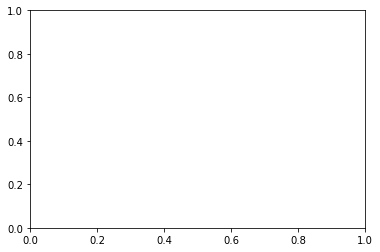

In [193]:
sns.kdeplot(df[df['Estado']=='Fallecido']['Edad'])

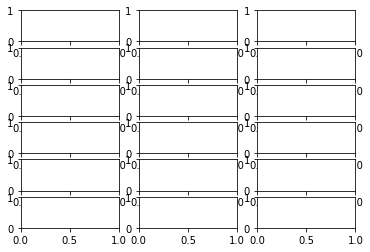

In [165]:
# plt.hist(df.Edad, bins = 30)
fig, axs = plt.subplots(6, 3)
axs[0,1] = plt.hist(df.Sexo)
axs[0,2] = plt.hist(df.Sexo)
plt.show()